### Interpretability - feature metrics

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')

X = coral_df[coral_df.columns.intersection(met_df['metabolite'])]
y = coral_df['scleractinia']
X = X.to_numpy()
y = y.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

/tmp/ipykernel_3012517/990327355.py:1: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")


accuracy 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        86

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



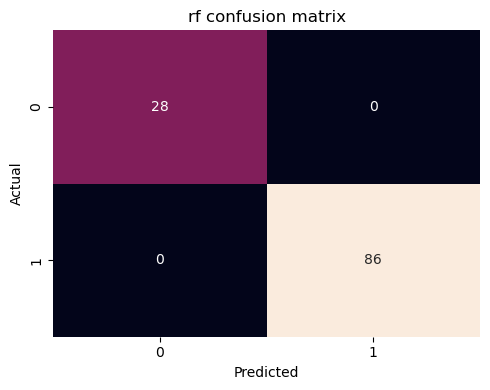

In [3]:
rf_path = "/work/hs325/World_Corals/machine_learning/models/RF_best_model.joblib"
rf = joblib.load(rf_path)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("rf confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


accuracy 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        86

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114



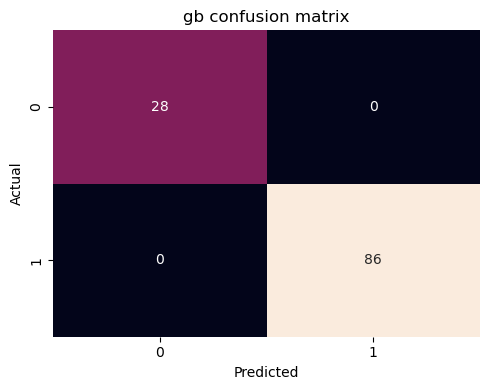

In [4]:
gb_path = "/work/hs325/World_Corals/machine_learning/models/GB_best_model.joblib"
gb = joblib.load(gb_path)
y_pred = gb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"accuracy {acc:.4f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True,cbar=False)
plt.title("gb confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


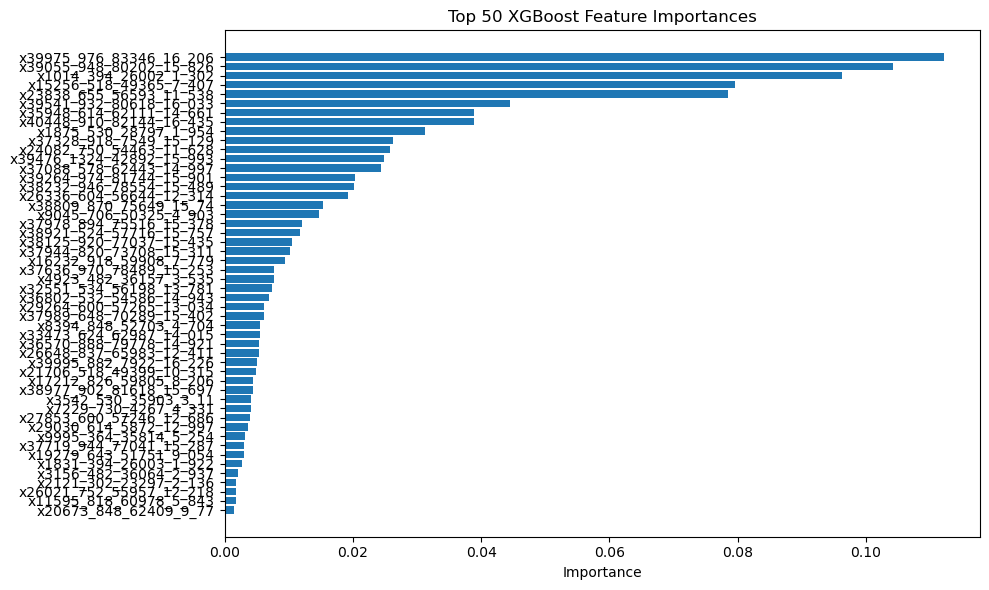

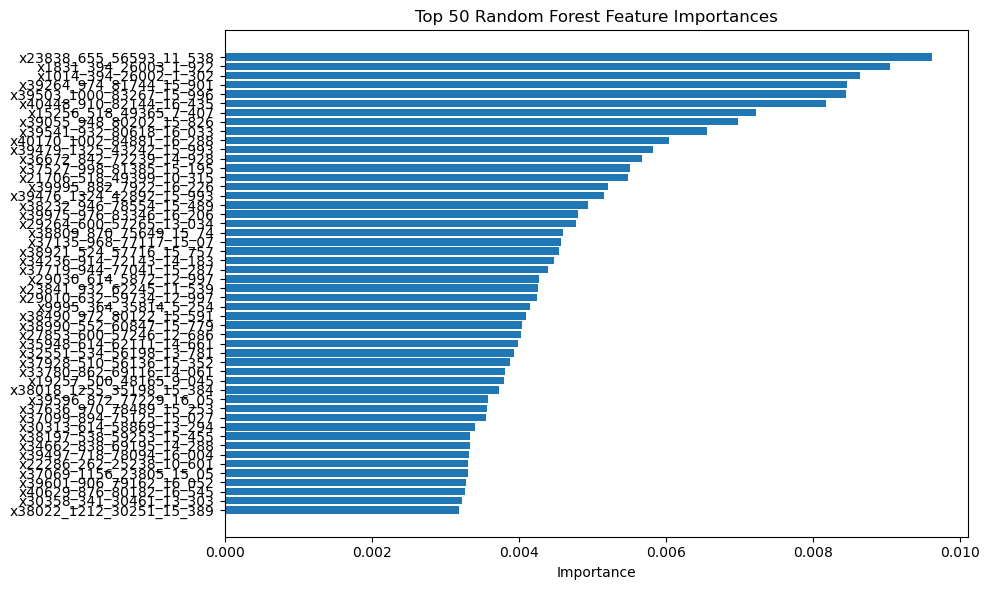

In [5]:
feature_names = coral_df.columns.intersection(met_df['metabolite'])

def get_feature_importances_df(gb_importances, rf_importances, feature_names):
    
    gb_df = pd.DataFrame({
        'Feature': feature_names,
        'XGBoost_Importance': gb_importances
    })

    rf_df = pd.DataFrame({
        'Feature': feature_names,
        'RandomForest_Importance': rf_importances
    })

    merged_df = pd.merge(gb_df, rf_df, on='Feature', how='outer')
    
    merged_df = merged_df.set_index('Feature')
    merged_df['Total_Importance'] = merged_df['XGBoost_Importance'] + merged_df['RandomForest_Importance']
    merged_df = merged_df.sort_values(by='Total_Importance', ascending=False)
    merged_df = merged_df.drop(columns=['Total_Importance'])
    return merged_df

def plot_top_features(importances, feature_names, title, top_n=50):
    indices = np.argsort(importances)[::-1][:top_n]
    top_features = np.array(feature_names)[indices]
    top_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_features)), top_importances[::-1])
    plt.yticks(range(len(top_features)), top_features[::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

feature_importance_comparison_df = get_feature_importances_df(
    gb.feature_importances_, 
    rf.feature_importances_, 
    feature_names
)

plot_top_features(gb.feature_importances_, feature_names, "Top 50 XGBoost Feature Importances", top_n=50)
plot_top_features(rf.feature_importances_, feature_names, "Top 50 Random Forest Feature Importances", top_n=50)

### Turn on CSV writing if needed

In [8]:
# feature_importance_comparison_df.to_csv("featureimportanceallmets.csv")

## Testing with host + both metabolites

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("loaded packages\n")

coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")
met_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/metabolite_clean.csv")

coral_df['scleractinia'] = np.where(coral_df['host_order'] == 'Scleractinia', 1, 0)
met_df['refined_origin'] = met_df['refined_origin'].str.replace('Host', 'Coral')

met_df_coral = met_df[
    (met_df['refined_origin'] == 'Coral') |
    (met_df['refined_origin'] == 'Both')
]

loaded packages



/tmp/ipykernel_421533/933754602.py:17: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_df = pd.read_csv("/work/hs325/World_Corals/Cleaned data CSVs/richness_qc_clean.csv")


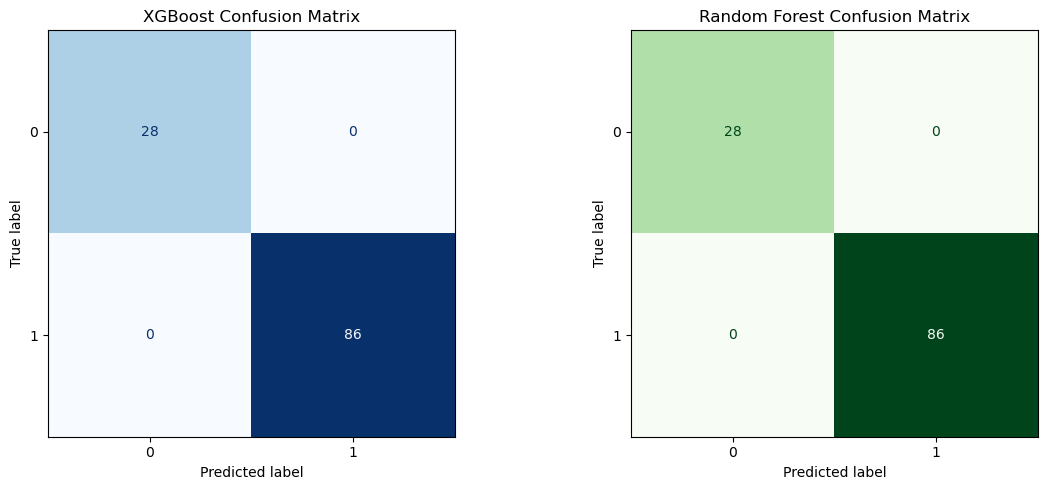

XGBoost Confusion Matrix:
 [[28  0]
 [ 0 86]]

Random Forest Confusion Matrix:
 [[28  0]
 [ 0 86]]


In [8]:
X = coral_df[coral_df.columns.intersection(met_df_coral['metabolite'])]
y = coral_df['scleractinia']
X = X.to_numpy()
y = y.to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

gb = XGBClassifier(random_state=123, n_jobs=-1)
gb.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=123, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_pred_rf = rf.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot XGBoost Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, 
                                        ax=ax[0], 
                                        cmap='Blues', 
                                        colorbar=False)
ax[0].set_title('XGBoost Confusion Matrix')

# Plot Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                        ax=ax[1], 
                                        cmap='Greens', 
                                        colorbar=False)
ax[1].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

# 4. Optional: Print raw text matrices if needed
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))